In [1]:
# Import packages needed

from yfinance import Ticker
import numpy as np
import pandas as pd
import scipy as si
import datetime
from yahoo_fin.stock_info import get_data
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import py_vollib_vectorized
import warnings
warnings.filterwarnings("ignore")

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


## Part 3. SSVI Parameterization

From Merill-Lynch 1999 and Gatheral 2004, the Stochastic Volatility Inspired (SVI) parameterization is a way to parameterize the implied volatility smile of at the money options. Specifically, it parameterizes the total implied variance, $w(k,T)$, which is defined as $$w(k,T) = \sigma^2_{BS}(k,T)T,$$ where $\sigma_{BS}(k,T)$ is the implied volatility of the option.

Hence, from Definition 3.2 in the paper, we have that: 

For a given maturity $T>0$, the raw SVI parameterization is given by $$w(k,T) = a_T+b_T\left(\rho_T(k-m_T)+\sqrt{(k-m_T)^2+\sigma^2_T}\right),$$ with $a_T \in \mathbb{R}, b_T \geq 0, |\rho_T|<1,m_T \in \mathbb{R}$ and $\sigma_T > 0$. Additionally $a_T+b_T\sigma_T\sqrt{1-\rho^2_T} \geq 0$ must hold, ensuring that the total implied variance remains positive $\forall k\in\mathbb{R}$.

To address the fact that the parameterization only concerns a slice of the total implied variance surface $k \rightarrow w(k,T)$ and that it seemed impossible to find conditions on the parameters to ensure absence of butterfly arbitrage, Gatheral and Jacquier 2014 propose the surface SVI (SSVI) parameterization.

Let $\phi$ be a smooth function from $\mathbb{R}^*_+$ to $\mathbb{R}^*_+$ such that the limit $\lim_{T\rightarrow 0}\theta_T\phi(\theta_T)$ exists in $\mathbb{R}$ where $\theta_T := \sigma^2_{BS}(0,T)T$ is the ATM total implied variance. The SSVI is the surface defined by: $$w(k,T) = \frac{\theta_T}{2}\left(1+\rho\phi(\theta_T)k+\sqrt{(\phi(\theta_T)k+\rho)^2+(1-\rho)^2}\right).$$

We will consider three distinct parameterizations for the function $\phi$:

\begin{align}
& \phi_{HL}(\theta) := \frac{1}{\lambda\theta}\left(1-\frac{1-e^{-\lambda\theta}}{\lambda\theta}\right) \quad \text{with } \lambda > 0, \\
& \phi_{PL}(\theta) := \frac{\eta}{\theta^\gamma} \quad \text{with } \eta > 0 \text{ and } 0<\gamma<1, \\
& \phi_{P}(\theta) := \frac{\eta}{\theta(1+\theta)} \quad \text{with } \eta > 0.


\end{align}



In [2]:
# Import S&P500 Data from 2003 to 2023
date_from = pd.to_datetime('1999-01-01') 
date_to = pd.to_datetime('2023-12-31') 
ticker = Ticker("^GSPC")
spot = ticker.history(start = date_from, end = date_to)


In [ ]:
# Change S&P500 dates to datetime
spot.index = pd.to_datetime(spot.index.date)

In [ ]:
# Use a modified version of Jack's option data importer/cleaner class object (added NaN value removing member funcion)

class spxCboeOptionPrices():
    def __init__(self):
        self.dfDict = {}
        return None
    
    def getStock(self, start_date, end_date):
        self.dfspx =  get_data("^GSPC", start_date=start_date, end_date=end_date)
        
    def addData(self, files):
        pathToFile = "C:/Users/Usuario/Desktop/QT Projects/"
        self.df = pd.read_csv(pathToFile + files[0])
        for f in files[1:]:
            dfTemp = pd.read_csv(pathToFile + f)
            self.df = pd.concat([self.df, dfTemp])
    
    def clean(self):
        self.df = self.df.drop(['issuer', 'optionid', 'index_flag', 'exercise_style'], axis=1)
        self.df["exdate"] = pd.to_datetime(self.df['exdate'])
        self.df["date"] = pd.to_datetime(self.df['date'])
        #df = df.loc[(df['best_bid'] <> 0.)] ## remove all the lines where the bid price is 0

        self.df['midP'] = 0.5*(self.df['best_offer'] + self.df['best_bid']) ## mid Prices
        
         ## convert maturities into time to maturity (in year)
        self.df['maturity'] = (self.df['exdate'] - self.df['date']) / np.timedelta64(1, 'D') / 365.25
        self.df.rename(columns={'strike_price': 'strike'}, inplace=True)
        self.df['strike'] = self.df['strike']/1000.
        print("Number of rows: ", len(self.df))
        self.allDates = self.df.drop_duplicates('date')['date'].tolist() ## Gets a list of all days
        
    def addSpot(self, dfspx):
        for t in self.allDates:
            print(dfspx.loc[dfspx.index == ("^GSPC",t.date())])
            St = dfspx.loc[dfspx.index == ("^GSPC",t.date())]['adjclose'].values[0] ## current value of the S&P
            self.df.loc[(self.df['date'] == t), 'Spot'] = St
    
    def computeFwdDF(self, currentDate, rr = [0.99, 1.01]):
        ## compute the forwards and discount Factors for a given currentDate
        #rr: bounds to eliminate the far-away strikes, i.e. K in (rd*St, ru*St)
        
        dfT = self.df.loc[self.df['date']==currentDate]
                
        dfTK = dfT.loc[(dfT['strike']>rr[0]*dfT["Spot"]) & (dfT['strike']<rr[1]*dfT["Spot"])]
        
        dfT["Fwd"] = 0.
        dfT["discountFactor"] = 0.
        
        ## Gets an array of all maturities on that day
        allMats = dfT.drop_duplicates('exdate')['exdate'].tolist()
        
        for tau in allMats:
            
            ddC = (dfTK.loc[(dfTK['exdate']==tau) & (dfTK['cp_flag']=="C")]).sort_values(by=['strike'], ascending=True)
            ddP = (dfTK.loc[(dfTK['exdate']==tau) & (dfTK['cp_flag']=="P")]).sort_values(by=['strike'], ascending=True)

            strikesC = ((ddC.drop_duplicates('strike')['strike']).sort_values())
            strikesP = ((ddP.drop_duplicates('strike')['strike']).sort_values())
            strikes  = ((pd.merge(strikesC.to_frame(), strikesP.to_frame(), on='strike')).iloc[:,0])

            if strikes.empty:
                continue

            parity = [(ddC.loc[ddC['strike']==K]['midP'].values[0]  - ddP.loc[ddP['strike']==K]['midP'].values[0]) for K in strikes.tolist()]
            model  = LinearRegression().fit(strikes.values.reshape((-1, 1)), parity)
            
            discountFactor = - model.coef_[0]
            forward = model.intercept_ / discountFactor
            
            dfT.loc[(dfT['exdate'] == tau), 'Fwd'] = forward
            dfT.loc[(dfT['exdate'] == tau), 'discountFactor'] = discountFactor
            
        self.dfDict[currentDate] = (dfT, allMats)

    def dropIVolNan(self):
        self.df = self.df.dropna(subset = ["impl_volatility"])



In [ ]:
# Import option data and clean it
files = ["optionMetricsSpx2022.csv"]
op = spxCboeOptionPrices()
op.addData(files)
op.clean()


Number of rows:  4961482


In [ ]:
# Visualize daily spot/close price
spx = spot['Close']
spx

1999-01-04    1228.099976
1999-01-05    1244.780029
1999-01-06    1272.339966
1999-01-07    1269.729980
1999-01-08    1275.089966
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: Close, Length: 6289, dtype: float64

In [ ]:
# Add spot/close price to option data
spx = spx.tz_localize(None)
op.df = op.df.merge(spx.rename('Spot'), 
                       left_on='date', 
                       right_index=True)

op.df


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike,best_bid,best_offer,...,suffix,cusip,ticker,sic,issue_type,div_convention,am_set_flag,midP,maturity,Spot
0,108105,2022-01-03,SPX 220121C1000000,1,2022-01-21,2021-12-22,C,1000.0,3787.3,3792.5,...,NaN,64881510,SPX,9999,A,I,NaN,3789.90,0.049281,4796.560059
1,108105,2022-01-03,SPX 220121C1100000,1,2022-01-21,2021-12-17,C,1100.0,3687.4,3692.5,...,NaN,64881510,SPX,9999,A,I,NaN,3689.95,0.049281,4796.560059
2,108105,2022-01-03,SPX 220121C1200000,1,2022-01-21,2021-12-23,C,1200.0,3587.3,3592.5,...,NaN,64881510,SPX,9999,A,I,NaN,3589.90,0.049281,4796.560059
3,108105,2022-01-03,SPX 220121C1300000,1,2022-01-21,2021-06-10,C,1300.0,3487.4,3492.6,...,NaN,64881510,SPX,9999,A,I,NaN,3490.00,0.049281,4796.560059
4,108105,2022-01-03,SPX 220121C1400000,1,2022-01-21,2021-12-17,C,1400.0,3387.4,3392.6,...,NaN,64881510,SPX,9999,A,I,NaN,3390.00,0.049281,4796.560059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961477,108105,2022-12-30,SPXW 231229P5000000,1,2023-12-29,2022-12-29,P,5000.0,1000.2,1014.4,...,NaN,64881510,SPX,9999,A,I,NaN,1007.30,0.996578,3839.500000
4961478,108105,2022-12-30,SPXW 231229P5025000,1,2023-12-29,NaN,P,5025.0,1022.0,1036.3,...,NaN,64881510,SPX,9999,A,I,NaN,1029.15,0.996578,3839.500000
4961479,108105,2022-12-30,SPXW 231229P5200000,1,2023-12-29,2022-12-29,P,5200.0,1178.2,1192.8,...,NaN,64881510,SPX,9999,A,I,NaN,1185.50,0.996578,3839.500000
4961480,108105,2022-12-30,SPXW 231229P5400000,1,2023-12-29,NaN,P,5400.0,1359.3,1382.9,...,NaN,64881510,SPX,9999,A,I,NaN,1371.10,0.996578,3839.500000


In [ ]:
# Drop NaN values and visualize final dataset
op.dropIVolNan()
op.df

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike,best_bid,best_offer,...,suffix,cusip,ticker,sic,issue_type,div_convention,am_set_flag,midP,maturity,Spot
223,108105,2022-01-03,SPX 220121C4390000,1,2022-01-21,2021-12-27,C,4390.0,403.0,407.2,...,NaN,64881510,SPX,9999,A,I,NaN,405.10,0.049281,4796.560059
224,108105,2022-01-03,SPX 220121C4395000,1,2022-01-21,2021-12-30,C,4395.0,398.1,402.1,...,NaN,64881510,SPX,9999,A,I,NaN,400.10,0.049281,4796.560059
225,108105,2022-01-03,SPX 220121C4400000,1,2022-01-21,2022-01-03,C,4400.0,393.2,397.2,...,NaN,64881510,SPX,9999,A,I,NaN,395.20,0.049281,4796.560059
226,108105,2022-01-03,SPX 220121C4405000,1,2022-01-21,2021-12-16,C,4405.0,388.3,392.3,...,NaN,64881510,SPX,9999,A,I,NaN,390.30,0.049281,4796.560059
227,108105,2022-01-03,SPX 220121C4410000,1,2022-01-21,2021-12-30,C,4410.0,383.2,387.5,...,NaN,64881510,SPX,9999,A,I,NaN,385.35,0.049281,4796.560059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961477,108105,2022-12-30,SPXW 231229P5000000,1,2023-12-29,2022-12-29,P,5000.0,1000.2,1014.4,...,NaN,64881510,SPX,9999,A,I,NaN,1007.30,0.996578,3839.500000
4961478,108105,2022-12-30,SPXW 231229P5025000,1,2023-12-29,NaN,P,5025.0,1022.0,1036.3,...,NaN,64881510,SPX,9999,A,I,NaN,1029.15,0.996578,3839.500000
4961479,108105,2022-12-30,SPXW 231229P5200000,1,2023-12-29,2022-12-29,P,5200.0,1178.2,1192.8,...,NaN,64881510,SPX,9999,A,I,NaN,1185.50,0.996578,3839.500000
4961480,108105,2022-12-30,SPXW 231229P5400000,1,2023-12-29,NaN,P,5400.0,1359.3,1382.9,...,NaN,64881510,SPX,9999,A,I,NaN,1371.10,0.996578,3839.500000


In [ ]:
# Make a list of dates
dates = op.df.drop_duplicates('date')['date'].tolist()
dates = [d.date() for d in dates]

In [ ]:
# Create a dataframe for each particular day in the dataset, calculating forward price and log-strike and dropping any non-interpretable values
# Note that filtering by volume and log-strike has been commented out in this demonstration
dfs = []
for test_day in range(len(dates)):
    op.computeFwdDF(op.allDates[test_day])
    test = op.df.loc[op.df["date"] == op.allDates[test_day]]
    # Calculate log-strike for each
    forwards = op.dfDict[op.allDates[test_day]][0]["Fwd"].values
    test["forward_price"] = forwards
    test["log_strike"] = np.log(test["strike"]/test["forward_price"])
    test['log_strike'] = test['log_strike'].replace([np.inf, -np.inf], np.nan)
    test['forward_price'] = test['forward_price'].replace([np.inf, -np.inf], np.nan)
    #test.head()
    test = test[test['forward_price']>0]
    test = test.sort_values('maturity')[test['maturity']>0.07]
    test = test[test['maturity']<25]
    test['maturity'] = np.round(test['maturity']/(1/12))
    test = test[test['maturity']<25]
    #test = test[test["volume"] > 1000]
    #test = test[(test["log_strike"] > -0.05) & (test["log_strike"] < 0.05)]
    dfs.append(test)




In [ ]:
# Define phi functions for SSVI, the Modified Power Law is also present but not implemented
def HL(lambd, eta, gamma, theta): # Heston-like phi
    return (1 / (lambd*theta))*(1-((1-np.exp(-lambd*theta))/(lambd*theta)))
def PL(lambd, eta, gamma, theta): # Power-law phi
    return eta/(theta**gamma)
def MPL(lambd, eta, gamma, theta): # Modified power-law phi
    return eta/(theta**gamma*((1+theta)**(1-gamma)))
def P(lambd, eta, gamma, theta): # Parsimonious phi
    return eta / np.sqrt(theta*(1+theta))

# Define SSVI ivol function (for simplicity)

def SSVIvol(lambd, eta, gamma, theta, phifunc, k, T, rho):
    return np.sqrt((1/T)*theta*0.5*(1+rho*phifunc(lambd, eta, gamma, theta)*k+np.sqrt((phifunc(lambd, eta, gamma, theta)*k+rho)**2 + (1-rho**2))))

# Define objective minimization functions for SSVI, one for each phi function

def HLObjective(params, fixed): # params is a list of thetas + rho + lambda / eta + gamma || fixed is the dataframe
    mats = fixed.drop_duplicates('maturity')['maturity'].tolist()
    theta_counter = 0
    objective = 0
    for tau in mats:
        temp = fixed.loc[fixed["maturity"] == tau].copy()
        temp["objective"] = si.stats.norm.pdf(temp["log_strike"])*(temp["impl_volatility"] - SSVIvol(params[-1], 0, 0, params[theta_counter], HL, temp["log_strike"], tau/12, params[-2]))**2
        tempsum = temp["objective"].sum()
        objective += tempsum
        theta_counter += 1
    return objective
    
def PLObjective(params, fixed): # params is a list of thetas + rho + lambda / eta + gamma || fixed is the dataframe
    mats = fixed.drop_duplicates('maturity')['maturity'].tolist()
    theta_counter = 0
    objective = 0
    for tau in mats:
        temp = fixed.loc[fixed["maturity"] == tau].copy()
        temp["objective"] = si.stats.norm.pdf(temp["log_strike"])*(temp["impl_volatility"] - SSVIvol(0, params[-2], params[-1], params[theta_counter], PL, temp["log_strike"], tau/12, params[-3]))**2
        tempsum = temp["objective"].sum()
        objective += tempsum
        theta_counter += 1
    return objective

def MPLObjective(params, fixed): # params is a list of thetas + rho + lambda / eta + gamma || fixed is the dataframe
    mats = fixed.drop_duplicates('maturity')['maturity'].tolist()
    theta_counter = 0
    objective = 0
    for tau in mats:
        temp = fixed.loc[fixed["maturity"] == tau].copy()
        temp["objective"] = si.stats.norm.pdf(temp["log_strike"])*(temp["impl_volatility"] - SSVIvol(0, params[-2], params[-1], params[theta_counter], MPL, temp["log_strike"], tau/12, params[-3]))**2
        tempsum = temp["objective"].sum()
        objective += tempsum
        theta_counter += 1
    return objective

def PObjective(params, fixed): # params is a list of rho + p + a + eta (Parsimonious function) || fixed is the dataframe
    mats = fixed.drop_duplicates('maturity')['maturity'].tolist()
    objective = 0
    for tau in mats:
        temp = fixed.loc[fixed["maturity"] == tau].copy()
        temp["objective"] = si.stats.norm.pdf(temp["log_strike"])*(temp["impl_volatility"] - SSVIvol(0, params[-1], 0, params[-2]*((tau/12)**params[-3]), P, temp["log_strike"], tau/12, params[-4]))**2
        tempsum = np.sum(temp["objective"].values)
        objective += tempsum
    return objective

In [ ]:
# Visualize 24/10/2022
test = dfs[203]
test

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike,best_bid,best_offer,...,ticker,sic,issue_type,div_convention,am_set_flag,midP,maturity,Spot,log_strike,w_kT
4043028,108105,2022-10-24,SPXW 221121P3500000,1,2022-11-21,2022-10-24,P,3500.0,28.1,28.6,...,SPX,9999,A,I,NaN,28.35,1.0,3797.340088,-0.081947,0.097321
4043029,108105,2022-10-24,SPXW 221121P3525000,1,2022-11-21,2022-10-24,P,3525.0,32.1,32.6,...,SPX,9999,A,I,NaN,32.35,1.0,3797.340088,-0.074830,0.095574
4043030,108105,2022-10-24,SPXW 221121P3550000,1,2022-11-21,2022-10-24,P,3550.0,36.5,37.0,...,SPX,9999,A,I,NaN,36.75,1.0,3797.340088,-0.067762,0.093703
4043031,108105,2022-10-24,SPXW 221121P3560000,1,2022-11-21,2022-10-24,P,3560.0,38.5,39.0,...,SPX,9999,A,I,NaN,38.75,1.0,3797.340088,-0.064949,0.093170
4043037,108105,2022-10-24,SPXW 221121P3610000,1,2022-11-21,2022-10-24,P,3610.0,49.5,50.0,...,SPX,9999,A,I,NaN,49.75,1.0,3797.340088,-0.051002,0.089894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036170,108105,2022-10-24,SPX 240621C3900000,1,2024-06-21,2022-10-21,C,3900.0,525.2,534.2,...,SPX,9999,A,I,NaN,529.70,20.0,3797.340088,-0.028384,1.351158
4036171,108105,2022-10-24,SPX 240621C3925000,1,2024-06-21,2022-09-02,C,3925.0,512.2,521.2,...,SPX,9999,A,I,NaN,516.70,20.0,3797.340088,-0.021994,1.337645
4036172,108105,2022-10-24,SPX 240621C3950000,1,2024-06-21,2022-10-21,C,3950.0,503.1,508.4,...,SPX,9999,A,I,NaN,505.75,20.0,3797.340088,-0.015645,1.334708
4036174,108105,2022-10-24,SPX 240621C400000,1,2024-06-21,2022-10-11,C,400.0,3323.7,3364.5,...,SPX,9999,A,I,NaN,3344.10,20.0,3797.340088,-2.305651,20.456617


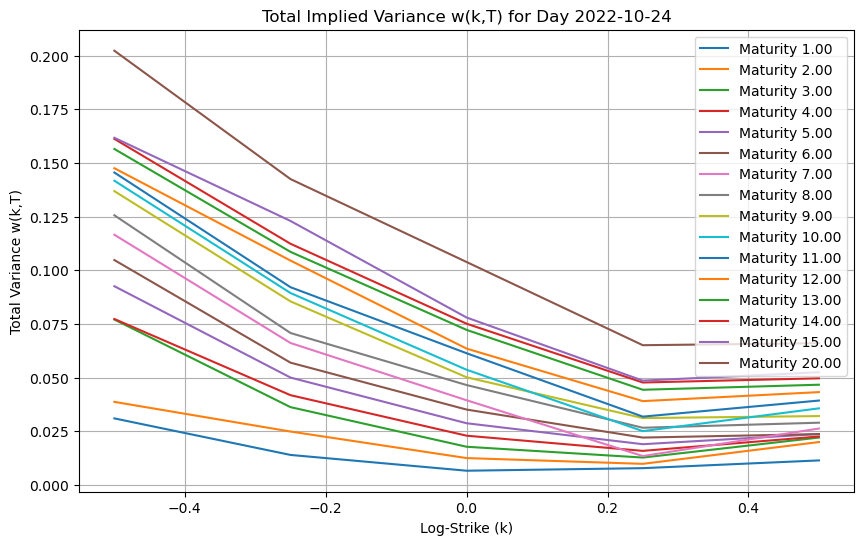

In [ ]:
# Plot market surfaces for 24/10/2022


for day_idx, day in enumerate(dfs):
    if day_idx != 203:
        continue
    plt.figure(figsize=(10, 6))
    mats = np.sort(day.drop_duplicates('maturity')['maturity'].tolist())
    k_plot = np.linspace(-0.5,0.5, 5)
    plot_date = pd.to_datetime(day['date'].iloc[0]).date()
        
    for tau in mats:
        ks = day.loc[day["maturity"] == tau]["log_strike"].values
        ivols = day.loc[day["maturity"] == tau]["impl_volatility"].values
        thetas = (tau/12)*ivols**2
        zipped = zip(ks, thetas)
        zip_sort = sorted(zipped, key = lambda x: x[0])
        ks_sorted, thetas_sorted = zip(*zip_sort)
        ks_sorted = np.array(ks_sorted)
        thetas_sorted = np.array(thetas_sorted)
        thetas_plot = np.interp(k_plot, ks_sorted, thetas_sorted)
        plt.plot(k_plot, thetas_plot, label=f"Maturity {tau:.2f}")

    plt.title(f"Total Implied Variance w(k,T) for Day {plot_date}")
    plt.xlabel("Log-Strike (k)")
    plt.ylabel("Total Variance w(k,T)")
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [ ]:
# Check sheet crossings to check for calendar arbitrage
def check_curve_crossing(k_plot, w1, w2):
    """
    Check if two curves w1 and w2 cross each other.
    Returns True if there is at least one crossing.
    """
    diff = w1 - w2
    crossings = np.where(np.diff(np.sign(diff)))[0]
    return len(crossings) > 0

# Initialize counters
total_days = 0
crossing_days = 0

for day_idx, day in enumerate(dfs):
    mats = np.sort(day.drop_duplicates('maturity')['maturity'].tolist())
    k_plot = np.linspace(-0.05, 0.05, 5)

    if 'date' in day.columns:
        plot_date = pd.to_datetime(day['date'].iloc[0]).date()
    else:
        plot_date = f"Day {day_idx}"

    # Store theta curves by maturity
    theta_curves = {}

    for tau in mats:
        ks = day.loc[day["maturity"] == tau]["log_strike"].values
        ivols = day.loc[day["maturity"] == tau]["impl_volatility"].values
        
        if len(ks) == 0:
            continue
        
        thetas = (tau/12) * ivols**2
        zipped = zip(ks, thetas)
        zip_sort = sorted(zipped, key=lambda x: x[0])
        ks_sorted, thetas_sorted = zip(*zip_sort)

        thetas_plot = np.interp(k_plot, ks_sorted, thetas_sorted)
        theta_curves[tau] = thetas_plot

    # Compare each pair of maturities
    maturities = list(theta_curves.keys())
    day_crossing = False

    for i in range(len(maturities)):
        for j in range(i+1, len(maturities)):
            tau_i = maturities[i]
            tau_j = maturities[j]

            w_i = theta_curves[tau_i]
            w_j = theta_curves[tau_j]

            if check_curve_crossing(k_plot, w_i, w_j):
                day_crossing = True
                break
        if day_crossing:
            break

    total_days += 1
    if day_crossing:
        crossing_days += 1
        print(f"{plot_date}: ✅ Crossing detected")
    else:
        print(f"{plot_date}: ❌ No crossings")

# Print crossings and percentage of days with crossings
percentage = (crossing_days / total_days) * 100
print("\nSummary:")
print(f"Total Days: {total_days}")
print(f"Days with Crossing: {crossing_days}")
print(f"Percentage of Days with Crossing: {percentage:.2f}%")



2022-01-03: ❌ No crossings
2022-01-04: ❌ No crossings
2022-01-05: ❌ No crossings
2022-01-06: ❌ No crossings
2022-01-07: ❌ No crossings
2022-01-10: ❌ No crossings
2022-01-11: ❌ No crossings
2022-01-12: ❌ No crossings
2022-01-13: ❌ No crossings
2022-01-14: ❌ No crossings
2022-01-18: ❌ No crossings
2022-01-19: ❌ No crossings
2022-01-20: ❌ No crossings
2022-01-21: ❌ No crossings
2022-01-24: ❌ No crossings
2022-01-25: ❌ No crossings
2022-01-26: ❌ No crossings
2022-01-27: ❌ No crossings
2022-01-28: ❌ No crossings
2022-01-31: ❌ No crossings
2022-02-01: ❌ No crossings
2022-02-02: ❌ No crossings
2022-02-03: ❌ No crossings
2022-02-04: ❌ No crossings
2022-02-07: ❌ No crossings
2022-02-08: ❌ No crossings
2022-02-09: ❌ No crossings
2022-02-10: ❌ No crossings
2022-02-11: ✅ Crossing detected
2022-02-14: ❌ No crossings
2022-02-15: ❌ No crossings
2022-02-16: ❌ No crossings
2022-02-17: ❌ No crossings
2022-02-18: ❌ No crossings
2022-02-22: ❌ No crossings
2022-02-23: ❌ No crossings
2022-02-24: ❌ No crossi

In [ ]:
# Set up initial guess and optimization problem constraings for Parsimonious SSVI

testparamsP = np.zeros(4) #  rho + p + a + eta (Parsimonious function)
testparamsP[-4], testparamsP[-3], testparamsP[-2], testparamsP[-1] = -0.5, 1, 0.5, 1 # rho = -0.5, p = 1, a = 0.5, eta = 1

def constraint_eta(params):
    eta = params[-1]  
    return eta - 1e-8 # eta > 0

def constraint_a(params):
    a = params[-2]  
    return a  # a ≥ 0

def constraint_rho_bounds(params):
    rho = params[-4]  
    return np.array([- 1e-8 + rho + 1, 1 - rho + 1e-8])  # -1 < rho < 1

def constraint_p(params):
    p = params[-3] 
    return p # lambda ≥ 0

# Define constraints in dictionary form for minimize function
constraintsP = [
    {'type': 'ineq', 'fun': constraint_eta},       
    {'type': 'ineq', 'fun': constraint_a},  
    {'type': 'ineq', 'fun': constraint_rho_bounds},     
    {'type': 'ineq', 'fun': constraint_p}
]


In [ ]:
# Run optimization
resultP = si.optimize.minimize(PObjective, testparamsP, args = (test,), constraints = constraintsP, method = "SLSQP")
resultP

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.7071016675798445
       x: [-4.609e-01  1.022e+00  6.471e-02  1.138e+00]
     nit: 18
     jac: [-5.409e-03  1.269e-03 -4.453e-03 -1.199e-03]
    nfev: 103
    njev: 18

In [ ]:
# Optimal parameters
optimalparamsP = resultP.get("x")
optimalparamsP

array([-0.46087976,  1.02154194,  0.06470711,  1.13762814])

In [ ]:
# Theta values
mats = np.sort(test.drop_duplicates('maturity')['maturity'].tolist())
thetas = np.array([optimalparamsP[-2]*((tau/12)**optimalparamsP[-3]) for tau in mats])

thetas


array([0.0051112 , 0.01037619, 0.01570082, 0.02106457, 0.02645759,
       0.03187405, 0.03731008, 0.04276292, 0.04823051, 0.05371122,
       0.05920377, 0.06470711, 0.07022034, 0.07574273, 0.08127363,
       0.10903848])

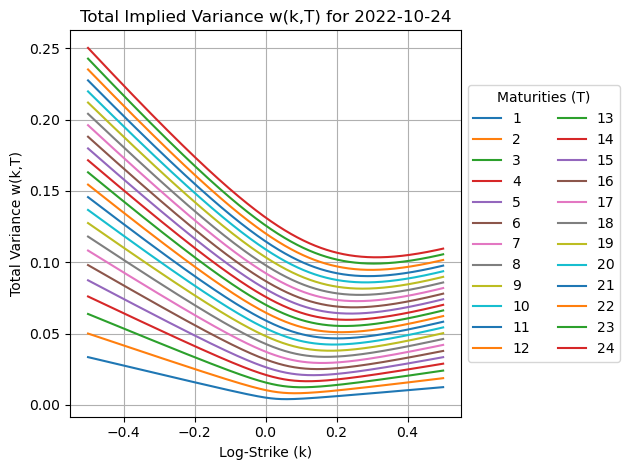

In [ ]:
# Plot surface sheets for Parsimonious SSVI

ks = np.linspace(-0.5, 0.5, 1000)
plot_date = pd.to_datetime(test['date'].iloc[0]).date()

for tau in range(1, 25):
    ivs_0 = (SSVIvol(0, optimalparamsP[-1], 0, optimalparamsP[-2]*((tau/12)**optimalparamsP[-3]), P, ks, tau/12, optimalparamsP[-4])**2) * tau / 12
    plt.plot(ks, ivs_0, label=f"{tau}")

plt.title(f"Total Implied Variance w(k,T) for {plot_date}")
plt.xlabel("Log-Strike (k)")
plt.ylabel("Total Variance w(k,T)")
plt.grid(True)


plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5),  
    ncol=2,
    title="Maturities (T)"
)

plt.tight_layout()
plt.savefig('ParSSVI.pdf', format='pdf')
plt.show()


In [ ]:
# Set up initial guess and optimization problem constraings for heston-like SSVI

mats = np.sort(test.drop_duplicates('maturity')['maturity'].tolist())
M = len(mats)

testparamsHL = np.zeros(M+2) # thetas + rho + lambda (HL function)

theta_counter = 0
for tau in mats:
    ks = test.loc[test["maturity"] == tau]["log_strike"].values
    ivols = test.loc[test["maturity"] == tau]["impl_volatility"].values
    thetas = (tau/12)*ivols**2
    zipped = zip(ks, thetas)
    zip_sort = sorted(zipped, key = lambda x: x[0])
    ks_sorted, thetas_sorted = zip(*zip_sort)
    theta = np.interp(0, ks_sorted, thetas_sorted)
    testparamsHL[theta_counter] = theta
    theta_counter += 1

testparamsHL[-2], testparamsHL[-1] = -0.5, 1


def constraint_theta_T1(params):
    theta = params[:-2]  
    return theta[0]  # thetaT1 ≥ 0

def constraint_monotonicity(params):
    theta = params[:-2]  
    return np.diff(theta)  # thetaTi+1 - thetaTi ≥ 0

def constraint_rho_bounds(params):
    rho = params[-2]  
    return np.array([- 1e-8 + rho + 1, 1 - rho + 1e-8])  # -1 < rho < 1

def constraint_lambda_positive(params):
    lambd = params[-1] 
    return lambd  # lambda > 0

def constraint_lambda_C_phi(params):
    rho = params[-2]
    lambd = params[-1]
    return lambd - (1 + abs(rho)) / 4  # lambda ≥ (1 + |rho|) / 4

# Define constraints in dictionary form for minimize function
constraintsHL = [
    {'type': 'ineq', 'fun': constraint_theta_T1},       
    {'type': 'ineq', 'fun': constraint_monotonicity},  
    {'type': 'ineq', 'fun': constraint_rho_bounds},     
    {'type': 'ineq', 'fun': constraint_lambda_positive}, 
    {'type': 'ineq', 'fun': constraint_lambda_C_phi}    
]

print(mats)
print(testparamsHL)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 20.]
[ 0.00655732  0.01244723  0.01772633  0.02288392  0.02868812  0.03505813
  0.03940407  0.04648651  0.05010747  0.05361523  0.06131672  0.06347178
  0.07219837  0.07508274  0.07796164  0.10384014 -0.5         1.        ]


In [ ]:
# Run optimization problem
resultHL = si.optimize.minimize(HLObjective, testparamsHL, args = (test,), constraints = constraintsHL, method = "SLSQP")
resultHL

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 29.095760699002998
       x: [ 8.098e-03  1.688e-02 ... -1.000e+00  5.000e-01]
     nit: 34
     jac: [ 4.603e-03  1.964e-03 ...  8.120e+00  1.176e-01]
    nfev: 684
    njev: 34

In [ ]:
# Visualize results
optimaltestparamsHL = resultHL.get("x")
optimaltestparamsHL

array([ 0.00809772,  0.01687862,  0.02218763,  0.02849183,  0.03612889,
        0.04250332,  0.05194904,  0.05818344,  0.06873028,  0.06873028,
        0.07811309,  0.08356902,  0.09409865,  0.09409865,  0.10140278,
        0.12905381, -0.99999995,  0.50000003])

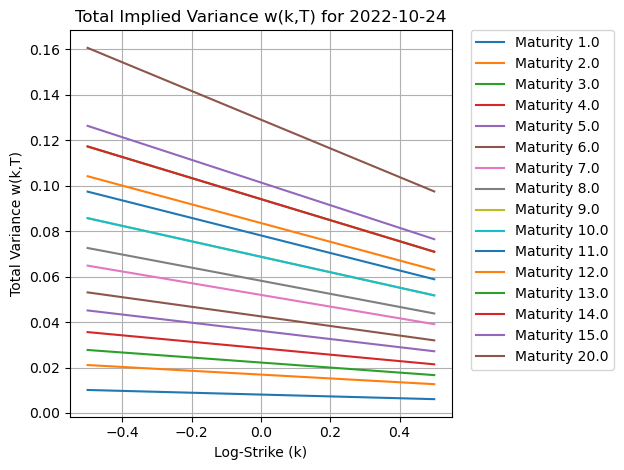

In [ ]:
# Plot Heston-like SSVI surface sheets
theta_count = 0
ks = np.linspace(-0.5, 0.5, 50)
plot_date = pd.to_datetime(test['date'].iloc[0]).date()

for tau in mats:
    ivs_0 = (SSVIvol(optimaltestparamsHL[-1], 0, 0, optimaltestparamsHL[theta_count], HL, ks, tau/12, optimaltestparamsHL[-2])**2) * (tau/12)
    plt.plot(ks, ivs_0, label=f"Maturity {tau}")
    theta_count += 1

plt.title(f"Total Implied Variance w(k,T) for {plot_date}")
plt.xlabel("Log-Strike (k)")
plt.ylabel("Total Variance w(k,T)")
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()  
plt.show()


In [ ]:
# Set up initial guess and optimization problem constraings for Power-law SSVI
mats = np.sort(test.drop_duplicates('maturity')['maturity'].tolist())
M = len(mats)

testparamsPL = np.zeros(M+3) # thetas + rho + eta + gamma (PL function)
theta_counter = 0
for tau in mats:
    ks = test.loc[test["maturity"] == tau]["log_strike"].values
    ivols = test.loc[test["maturity"] == tau]["impl_volatility"].values
    thetas = (tau/12)*ivols**2
    zipped = zip(ks, thetas)
    zip_sort = sorted(zipped, key = lambda x: x[0])
    ks_sorted, thetas_sorted = zip(*zip_sort)
    theta = np.interp(0, ks_sorted, thetas_sorted)
    testparamsPL[theta_counter] = theta
    theta_counter += 1
    
testparamsPL[-3], testparamsPL[-2], testparamsPL[-1] = -0.5, 1, 0.25

def constraint_theta_T1(params):
    theta = params[:-3]  
    return theta[0]  # thetaT1 ≥ 0

def constraint_monotonicity(params):
    theta = params[:-3]  
    return np.diff(theta)  # thetaTi+1 - thetaTi ≥ 0

def constraint_rho_bounds(params):
    rho = params[-3]  
    return np.array([- 1e-8 + rho + 1, 1 - rho + 1e-8])  # -1 < rho < 1

def constraint_gamma_bounds(params):
    gamma = params[-1]  
    return np.array([gamma, 1 - gamma])  # 0 < gamma < 1

def constraint_eta_positive(params):
    eta = params[-2] 
    return eta  # eta > 0

def constraint_lambda_C_phi(params):
    rho = params[-3]
    eta = params[-2]
    gamma = params[-1]
    if gamma == 0.5:
        return 4 - (eta**2)*(1 + abs(rho)) # 4 ≥ eta^2*(1 + |rho|)
    return 0 

# Define constraints in dictionary form for minimize function
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_T1},       
    {'type': 'ineq', 'fun': constraint_monotonicity},  
    {'type': 'ineq', 'fun': constraint_rho_bounds},     
    {'type': 'ineq', 'fun': constraint_lambda_positive}, 
    {'type': 'ineq', 'fun': constraint_lambda_C_phi}    
]

print(mats)
print(testparamsPL)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 20.]
[ 0.00655732  0.01244723  0.01772633  0.02288392  0.02868812  0.03505813
  0.03940407  0.04648651  0.05010747  0.05361523  0.06131672  0.06347178
  0.07219837  0.07508274  0.07796164  0.10384014 -0.5         1.
  0.25      ]


In [ ]:
# Run optimization problem
resultPL = si.optimize.minimize(PLObjective, testparamsPL, args = (test,), constraints = constraints, method = "SLSQP")
resultPL

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.36030235632183
       x: [ 5.353e-03  1.140e-02 ...  2.046e+00  3.500e-01]
     nit: 42
     jac: [-1.414e-01  3.647e-02 ... -6.924e-04 -4.189e-03]
    nfev: 891
    njev: 42

In [ ]:
# Visualize results
optimaltestparamsPL = resultPL.get("x")
optimaltestparamsPL

array([ 0.00535298,  0.01140198,  0.01624011,  0.02147747,  0.02590893,
        0.03129208,  0.03501613,  0.04004286,  0.04540037,  0.04902821,
        0.05346684,  0.05880615,  0.06260328,  0.06516214,  0.07087725,
        0.09062249, -0.4655061 ,  2.0459067 ,  0.35004132])

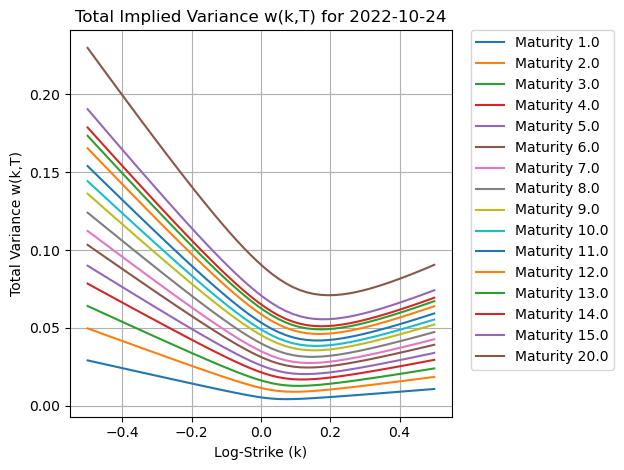

In [ ]:
# Plot Power-law SSVI surface sheets
theta_count = 0
ks = np.linspace(-0.5, 0.5, 50)
plot_date = pd.to_datetime(test['date'].iloc[0]).date()

for tau in mats:
    ivs_0 = (tau/12)*(SSVIvol(0, optimaltestparamsPL[-2], optimaltestparamsPL[-1], optimaltestparamsPL[theta_count], PL, ks, tau/12, optimaltestparamsPL[-3])**2)
    plt.plot(ks, ivs_0, label=f"Maturity {tau}")
    theta_count += 1

plt.title(f"Total Implied Variance w(k,T) for {plot_date}")
plt.xlabel("Log-Strike (k)")
plt.ylabel("Total Variance w(k,T)")
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()  
plt.show()


In [ ]:
# Define a function to compute mean errors and mean percentage errors

def evaluate_model(test_data, mats, params_HL, params_P, params_PL):
    hl_errors = []
    p_errors = []
    pl_errors = []
    hl_percentage_errors = []
    p_percentage_errors = []
    pl_percentage_errors = []
    theta_count = 0

    for tau in mats:

        temp = test_data.loc[test_data['maturity'] == tau]
        ks = temp['log_strike'].values
        iv_market = temp['impl_volatility'].values
        
        # HL model volatilities
        iv_model_HL = SSVIvol(params_HL[-1], 0, 0, params_HL[theta_count], HL, ks, tau/12, params_HL[-2])
        
        # P model volatilities
        iv_model_P = SSVIvol(0, params_P[-1], 0, params_P[-2]*((tau/12)**params_P[-3]), P, ks, tau/12, params_P[-4])

        # PL model volatilities
        iv_model_PL = SSVIvol(0, params_PL[-2], params_PL[-1], params_PL[theta_count], PL, ks, tau/12, params_PL[-3])

        # Compute absolute errors
        error_HL = np.abs(iv_model_HL - iv_market)
        error_P = np.abs(iv_model_P - iv_market)
        error_PL = np.abs(iv_model_PL - iv_market)

        # Compute percentage errors (safe divide)
        perc_error_HL = np.where(iv_market != 0, 100 * error_HL / iv_market, 0)
        perc_error_P = np.where(iv_market != 0, 100 * error_P / iv_market, 0)
        perc_error_PL = np.where(iv_market != 0, 100 * error_PL / iv_market, 0)

        # Store errors
        hl_errors.extend(error_HL)
        p_errors.extend(error_P)
        pl_errors.extend(error_PL)
        hl_percentage_errors.extend(perc_error_HL)
        p_percentage_errors.extend(perc_error_P)
        pl_percentage_errors.extend(perc_error_PL)

        theta_count += 1

    hl_errors = np.array(hl_errors)
    p_errors = np.array(p_errors)
    pl_errors = np.array(pl_errors)
    hl_percentage_errors = np.array(hl_percentage_errors)
    p_percentage_errors = np.array(p_percentage_errors)
    pl_percentage_errors = np.array(pl_percentage_errors)

    # Print out different metrics
    print(f"HL Model - MAE: {np.mean(hl_errors):.6f}, RMSE: {np.sqrt(np.mean(hl_errors**2)):.6f}")
    print(f"P Model - MAE: {np.mean(p_errors):.6f}, RMSE: {np.sqrt(np.mean(p_errors**2)):.6f}")
    print(f"PL Model - MAE: {np.mean(pl_errors):.6f}, RMSE: {np.sqrt(np.mean(pl_errors**2)):.6f}")
    print()
    print(f"HL Model - Mean % Error: {np.mean(hl_percentage_errors):.2f}%")
    print(f"P Model - Mean % Error: {np.mean(p_percentage_errors):.2f}%")
    print(f"PL Model - Mean % Error: {np.mean(pl_percentage_errors):.2f}%")

    return hl_errors, p_errors, pl_errors, hl_percentage_errors, p_percentage_errors, pl_percentage_errors


In [ ]:
# Compute error metrics
hl_errors, p_errors, pl_errors, hl_percentage_errors, p_percentage_errors, pl_percentage_errors = evaluate_model(test, mats, optimaltestparamsHL, optimalparamsP, optimaltestparamsPL)

===== Error Metrics =====
HL Model - MAE: 0.063011, RMSE: 0.123134
P Model - MAE: 0.022816, RMSE: 0.049949
PL Model - MAE: 0.021764, RMSE: 0.048080

HL Model - Mean % Error: 17.28%
P Model - Mean % Error: 6.51%
PL Model - Mean % Error: 6.19%
